# ToDo

    Get train and test error results from different regularization parameter values (Grid Search)
    Get a baseline recommender based on average rating per wine
        Reference: http://ampcamp.berkeley.edu/5/exercises/movie-recommendation-with-mllib.html

In [44]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cPickle
import pyspark
import pylab
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from collections import defaultdict, Counter
from sklearn import metrics
% matplotlib inline

In [5]:
from pyspark.mllib.recommendation import ALS
import math

In [6]:
def get_ratings_data():
    # load spark ready data 
    spark_ready_data_path = "/Users/Alexander/Wine_Recommender/data/spark_ready_data.pkl"
    ratings_data = cPickle.load(open(spark_ready_data_path, "r"))
    return ratings_data

In [5]:
data = get_ratings_data()

In [6]:
data[0:3]

[['00000F7264C27BA6FEA0C837ED6AA0AA', 202463, 9],
 ['00000F7264C27BA6FEA0C837ED6AA0AA', 202922, 6],
 ['00000F7264C27BA6FEA0C837ED6AA0AA', 214365, 6]]

In [77]:
dummy_X = np.array([1,1,1,1,1,1])
dummy_Y = np.array([1,1,1,2,2,2])

In [79]:
sss = StratifiedShuffleSplit(dummy_Y, n_iter=1, test_size=0.5, random_state=4)

In [80]:
for tr, te in sss:
    print dummy_X[tr], dummy_Y[tr]
    print dummy_X[te], dummy_Y[te]

[1 1 1 1] [1 2 2 1]
[1 1] [1 2]


#### Create Spark Context

In [7]:
# number of nodes in local spark cluster
n_nodes = 3
sc = pyspark.SparkContext(master = "local[{}]".format(n_nodes))

In [8]:
sc

#### Create user tags/user ids bride rdd

In [9]:
def create_cust_tag_bridge_rdd(data, sc):
    # create int:cust_tag key value pairs
    # spark can't read string user ids
    
    unique_user_tags = np.unique([row[0] for row in data])
    
    index_to_int = np.arange(0, len(unique_user_tags) * 100, 100)
    cust_tag_bridge = [ (tag_hash, tag_int) for tag_hash, tag_int in zip(unique_user_tags, index_to_int)]
    
    return sc.parallelize(cust_tag_bridge)

In [16]:
cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)

#### Ratings RDD

In [10]:
def create_clean_data_rdd(data, cust_tag_bridge_rdd):
    # create bride rdd for customer tags and customer ids
    data_rdd = sc.parallelize(data)
    
    tag_data_bridge_rdd = data_rdd.map(lambda row: (row[0], (row[1], row[2]) ))
    
    clean_data_rdd = \
    tag_data_bridge_rdd.sortByKey()\
                   .join( cust_tag_bridge_rdd.sortByKey())\
                   .map(lambda row: ( row[1][1], row[1][0][0], row[1][0][1]))
            
    return clean_data_rdd

In [17]:
clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 

In [18]:
# format --> (user_id, productKey, rating)
clean_data_rdd.take(3)

[(13720100, 11501, 10), (13720100, 83729, 4), (13720100, 85684, 4)]

In [11]:
# split for train_test_split inside of LOOCV function  
def split_data(data_rdd):
    '''Collect data from rdd and split into X and Y'''
    ratings_data = data_rdd.collect()
    X = []
    Y = []
    for row in ratings_data:
        X.append([row[0], row[1]])
        Y.append(row[2])
    return X, Y

In [19]:
X, Y = split_data(clean_data_rdd)

In [315]:
len(X)

3737914

In [19]:
print X[0:3]

[[13720100, 11501], [13720100, 83729], [13720100, 85684]]


In [20]:
print Y[0:3]

[10, 4, 4]


#### Split Data into train and holdout sets

In [21]:
X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, Y, test_size = 0.20, random_state=4)

In [22]:
len(X_holdout)

747583

In [23]:
len(X_train)

2990331

## LOOCV
    Leave One Out Cross Validation
    Use StratifiedShuffleSplit to get train/test sets with ~equal numbers of labels (Global Split)

In [18]:
# LOOCV
# The data is split in the follow fasion (ignore the numbers inside the lists)
# [5] [6, 7, 8, 9, 10, 11, 12, 13, 14]
# [5, 6] [7, 8, 9, 10, 11, 12, 13, 14]
# [5, 6, 7] [8, 9, 10, 11, 12, 13, 14]
# [5, 6, 7, 8] [9, 10, 11, 12, 13, 14]
# [5, 6, 7, 8, 9] [10, 11, 12, 13, 14]
# [5, 6, 7, 8, 9, 10] [11, 12, 13, 14]
# [5, 6, 7, 8, 9, 10, 11] [12, 13, 14]
# [5, 6, 7, 8, 9, 10, 11, 12] [13, 14]
# [5, 6, 7, 8, 9, 10, 11, 12, 13] [14]

In [14]:
# Global split - train/test sets with proportinal label distribution
# (y, n_iter=10, test_size=0.1, train_size=None, random_state=None
def get_loocv_train_test_errors(sc,  alpha = 0.1, rank_ = 16, n_iterations= 20):
    
    def predict_get_error(model, data, data_predict):
        # (r[0], r[1]), r[2]) --> user_id, wine_id, rating 
        predictions = model.predictAll(data_predict).map(lambda r: ((r[0], r[1]), r[2]))

        # combine predictions and validation sets
        rates_and_preds = data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2])))\
                                        .join(predictions)
        # get RMSE for each rank
        error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
        return error
    
    # load data
    print "load data..."
    data = get_ratings_data()
    print "build RDDs..."
    cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)
    clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 
    X, Y = split_data(clean_data_rdd)
    
    cust_tag_bridge_rdd.unpersist()
    clean_data_rdd.unpersist()
    
    seed = 5L
    iterations = n_iterations
    regularization_parameter = alpha
    rank = rank_
    global_test_sizes = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    train_errors = []
    test_errors = []
    
    X = np.array(X)
    Y = np.array(Y)

    for i, test_size_ in enumerate(global_test_sizes):
        
        print "Iteration {}".format(i)
        # Stratified KFold 
        sss = StratifiedShuffleSplit(Y, n_iter=1, test_size=test_size_, random_state=4)
        for train, test in sss:
            X_train, y_train = X[train], Y[train]
            X_test, y_test = X[test], Y[test]

        
#         X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                             Y, 
#                                                             test_size = global_test_size,
#                                                             random_state=4)
        
        train_rdd_ready = [(tuple(x)[0], tuple(x)[1], y) for x, y in zip(X_train, y_train)]
        test_rdd_ready = [(tuple(x)[0], tuple(x)[1], y) for x, y in zip(X_test, y_test)]

        train_data_rdd = sc.parallelize(train_rdd_ready)
        test_data_rdd = sc.parallelize(test_rdd_ready)
        
        model = ALS.train(
                  ratings=train_data_rdd, 
                  rank=rank, 
                  seed=seed, 
                  iterations=iterations,
                  lambda_=regularization_parameter,
                  nonnegative=True)
        
        train_data_for_predict_rdd = train_data_rdd.map(lambda row: (row[0], row[1]))
        test_data_for_predict_rdd = test_data_rdd.map(lambda row: (row[0], row[1]))

        train_error = predict_get_error(model, train_data_rdd, train_data_for_predict_rdd)
        train_errors.append(train_error)

        test_error = predict_get_error(model, test_data_rdd, test_data_for_predict_rdd)
        test_errors.append(test_error)

        # unpersist to release memory 
        train_data_rdd.unpersist()
        test_data_rdd.unpersist()

    return train_errors, test_errors

In [2]:
start = time()
train_errors, test_errors = get_loocv_train_test_errors(sc)
end = time()
print "Time Elapsed = {}".format(end -  start)

#### Load LOOCV Results

In [2]:
loocv_path = "/Users/Alexander/Wine_Recommender/data/loocv_results.pkl"
train_errors, test_errors = cPickle.load(open(loocv_path, 'r'))

In [3]:
type(train_errors)

list

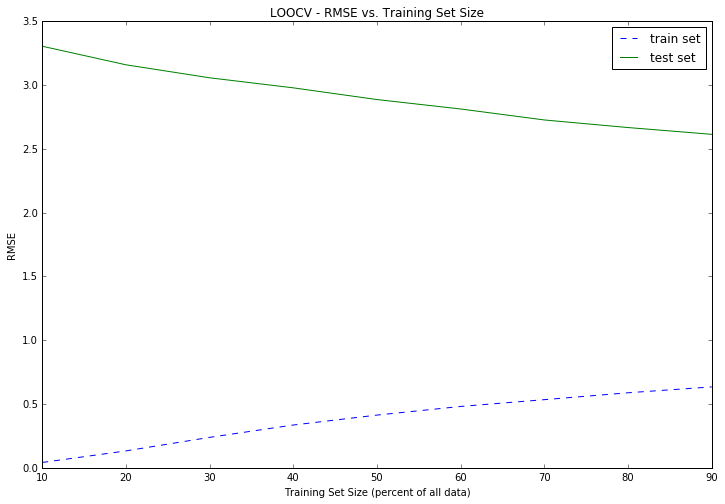

In [4]:
x_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
plt.figure(figsize = (12,8));
plt.title("LOOCV - RMSE vs. Training Set Size");
plt.ylabel("RMSE");
plt.xlabel("Training Set Size (percent of all data)");
plt.plot(x_values, train_errors,'b--', label="train set");
plt.plot(x_values, test_errors,"g-", label="test set");
plt.legend();
plt.savefig("/Users/Alexander/Wine_Recommender/data/RMSE_vs_Training_Set_Size.png")

## Regularization 
    Here, we'll scan parameter space for the optimum vlaue of lambda -- the regulariation parameter

In [ ]:
reg_parameters = [1.0, 0.1, 0.01, 0.001]

In [ ]:
def get_regularization_results(reg_parameters, X, Y, sc):
    train_errors_dict = dict()
    test_errors_dict = dict()
    for param in reg_parameters:
        print "Starting {}".format(param)
        train_errors, test_errors = get_loocv_train_test_errors(X, Y, sc, param)
        train_errors_dict[param] = train_errors
        test_errors_dict[param] = test_errors
    return train_errors_dict, test_errors_dict

In [ ]:
start = time()
train_dict, test_dict = get_regularization_results(reg_parameters, x_sub, y_sub , sc_local)
end = time()
print "Time Elapsed = {}".format(end - start)

Here we can see the train and test error results from varying the value of the L2 regularization term, alpha. 
The plot shows that a regularization value of 0.1 results in the lowest test RMSE.

In [ ]:
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

In [ ]:
plt.legend?

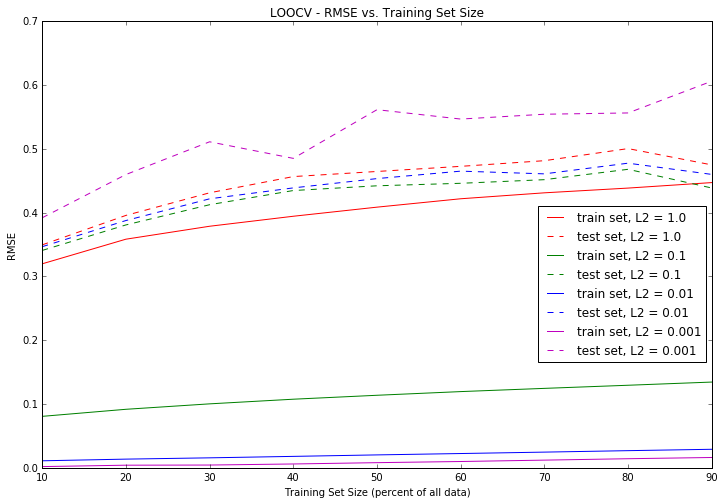

In [34]:
x_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
colormap = np.array(['r', 'g', 'b','m'])
plt.figure(figsize = (12,8));
plt.title("LOOCV - RMSE vs. Training Set Size");
plt.ylabel("RMSE");
plt.xlabel("Training Set Size (percent of all data)");
for i, param in enumerate(reg_parameters):
    train = np.array(train_dict[param])
    test = np.array(test_dict[param])
    plt.plot(x_values, train,  c=colormap[i],   label="train set, L2 = {}".format(param));
    plt.plot(x_values, test,  c=colormap[i],linestyle="dashed", label="test set, L2 = {}".format(param));
plt.legend(bbox_to_anchor=(1.0, 0.6));
#plt.savefig("/Users/Alexander/WINE/data/L2_parameter_scan.png")

# Grid Search
    Run with Sub_sample, other it will take days...

In [7]:
def grid_search(sc, reg_parameters, ranks, iterations):
    print "get_ratings_data...."
    data = get_ratings_data()
    print "build RDDS...."
    cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)
    clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 
    X, Y =  split_data(clean_data_rdd)
    
    intial = 0
    final = 1000000
    x_sub, y_sub = X[intial:final], Y[intial:final]
    
    cust_tag_bridge_rdd.unpersist()
    clean_data_rdd.unpersist()
    
    
    train_errors_dict = dict()
    test_errors_dict = dict()
    print "run grid search...."
    for alpha in reg_parameters:
        for rank in ranks:
            for n_iter in iterations:
                start = time()
                print "alpha_{0}, rank_{1}, n_iter_{2}".format(alpha, rank, n_iter)
                train_errors, test_errors = get_loocv_train_test_errors(x_sub, y_sub, sc, alpha, rank, n_iter )
                train_key = "alpha_{0}, rank_{1}, n_iter_{2}".format(alpha, rank, n_iter)
                test_key = "alpha_{0}, rank_{1}, n_iter_{2}".format(alpha, rank, n_iter)
                train_errors_dict[train_key] = train_errors
                test_errors_dict[test_key] = test_errors
                end = time()
                print "Time Elapsed = {}".format(end - start)
                
    return train_errors_dict, test_errors_dict

In [8]:
reg_parameters = [0.01, 0.1]
ranks = [16, 20, 24]
iterations = [20, 30, 40]

In [1]:
start = time()
gs_train_errors, gs_test_errors = grid_search(sc, reg_parameters, ranks, iterations)
end = time()
print "Time Elapsed = {}".format(end - start)

### Save Grid Search Results to File

In [2]:
gs_path = "/Users/Alexander/WINE/data/grid_search_results.pkl"

In [21]:
#cPickle.dump([gs_train_errors, gs_test_errors], open(gs_path, 'w'))

### Load Grid Search Results from File

In [5]:
gs_results_list =  cPickle.load(open(gs_path, 'r'))

In [74]:
gs_train_errors, gs_test_errors = gs_results_list

In [75]:
gs_keys = np.unique(gs_train_errors.keys())

In [76]:
len(gs_keys)

18

The plot below shows the train and test errors for all combinations of the hyperparameters included in the grid search. There seems to be to 2 error categories: those with low training error and those with higher training error. 

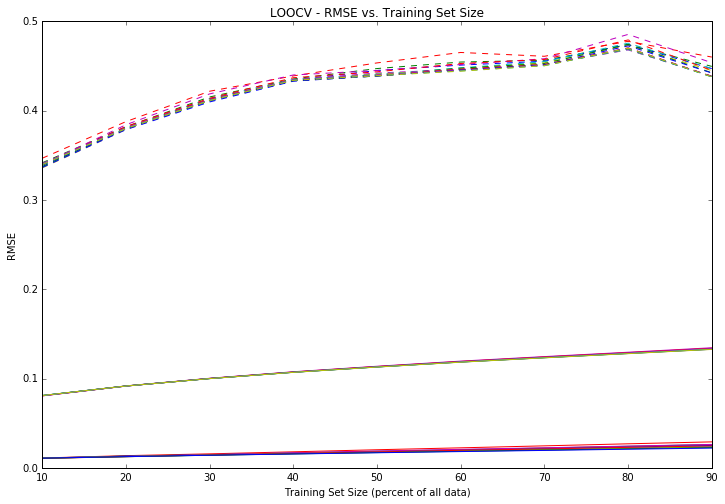

In [24]:
x_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
colormap = np.array(['r', 'g', 'b','m', 'c', 'y', 'k'])
plt.figure(figsize = (12,8));
plt.title("LOOCV - RMSE vs. Training Set Size");
plt.ylabel("RMSE");
plt.xlabel("Training Set Size (percent of all data)");

i = 0
for gs_key in gs_keys:
    train = gs_train_errors[gs_key]
    test = gs_test_errors[gs_key]
    plt.plot(x_values, train,  c=colormap[i],  label="train set, L2 = {}".format(gs_key));
    plt.plot(x_values, test,  c=colormap[i], linestyle="dashed", label="test set, L2 = {}".format(gs_key));
    
    i += 1
    if i == 6:
        i = 0
#plt.legend();

In [108]:
def get_lowest_error_indices(gs_errors, k =6):
    ind = []
    for i, errors in  enumerate(gs_errors.values()):
        ind.append([i, errors[-1]])
    ind = np.array(ind)
    return ind[ind.argsort(axis = 0).T[1]][-k:].T[0]

In [113]:
lowest_error_indices = get_lowest_error_indices(gs_test_errors, k =3)

The 3 hyper-parameters combinations with the lowest test error are shown below. The results converge on 0.01 for alpha and, for this gridsearch iteration, it seems that the more latent features and more iterations for the ALS that are provdied, the lower the test error. Of course, those two parameters cannot be increased indefiniately; they will hit a saturation point. 

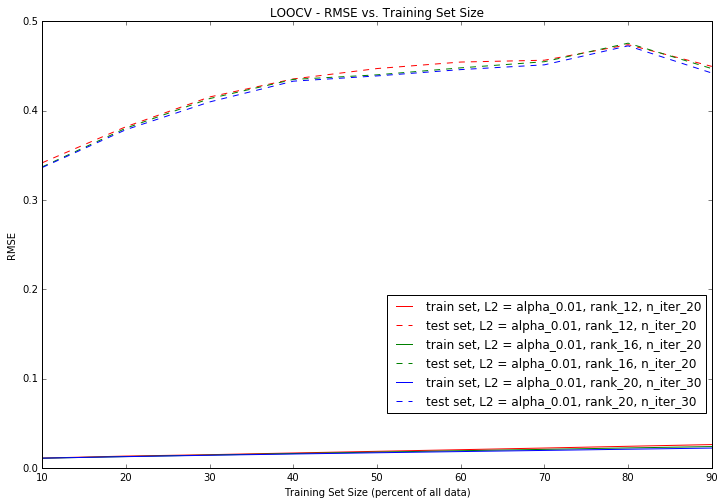

In [114]:
x_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
colormap = np.array(['r', 'g', 'b','m', 'c', 'y', 'k'])
plt.figure(figsize = (12,8));
plt.title("LOOCV - RMSE vs. Training Set Size");
plt.ylabel("RMSE");
plt.xlabel("Training Set Size (percent of all data)");

cnt = 0
for i, gs_key in enumerate(gs_keys):
    if i in lowest_error_indices:
        train = gs_train_errors[gs_key]
        test = gs_test_errors[gs_key]
        plt.plot(x_values, train,  c=colormap[cnt],  label="train set, L2 = {}".format(gs_key));
        plt.plot(x_values, test,  c=colormap[cnt], linestyle="dashed", label="test set, L2 = {}".format(gs_key));
    
        cnt += 1
        if cnt == 6:
            cnt = 0
plt.legend(bbox_to_anchor=(1.0, 0.4));

# ROC Curves
    Train and Test a model. 
    Include a ROC curve for each bin.

### Get Predicted Ratings 

In [1]:
def create_cust_tag_bridge_rdd(data, sc):
    # create int:cust_tag key value pairs
    # spark can't read string user ids
    
    unique_user_tags = np.unique([row[0] for row in data])
    
    index_to_int = np.arange(0, len(unique_user_tags) * 100, 100)
    cust_tag_bridge = [ (tag_hash, tag_int) for tag_hash, tag_int in zip(unique_user_tags, index_to_int)]
    
    return sc.parallelize(cust_tag_bridge)

In [2]:
def create_clean_data_rdd(data, cust_tag_bridge_rdd):
    # create bride rdd for customer tags and customer ids
    data_rdd = sc.parallelize(data)
    
    tag_data_bridge_rdd = data_rdd.map(lambda row: (row[0], (row[1], row[2]) ))
    
    clean_data_rdd = \
    tag_data_bridge_rdd.sortByKey()\
                   .join( cust_tag_bridge_rdd.sortByKey())\
                   .map(lambda row: ( row[1][1], row[1][0][0], row[1][0][1]))
            
    return clean_data_rdd

In [3]:
def train_model(training_RDD):
    # TODO: still need to optimize hyperparameters in a grid search
    seed = 5L
    iterations = 30
    regularization_parameter = 0.1
    rank = 20

    model = ALS.train(training_RDD, 
                      rank=rank, 
                      seed=seed, 
                      iterations=iterations,
                      lambda_=regularization_parameter,
                      nonnegative=True)
    return model

In [4]:
def test_model(model, test_RDD, test_for_predict_RDD ):

    predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))

    rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)

    error = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        
    print "Testing Error {:.3}".format(error)
    return predictions

In [17]:
def get_test_results(sc):
    '''Returns ratings test set and predicted ratings on test set'''
    
    print "get_ratings_data..."
    data = get_ratings_data()
    print "building RDDs...."
    cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)
    clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 
    
    # free up memnory resources
    cust_tag_bridge_rdd.unpersist()
    print "spliting data into train and test set..."
    # split data into sets in appropriate proprotions, i.e. weights = [8, 2]
    training_RDD, test_RDD = clean_data_rdd.randomSplit([8, 2], seed=0)
    
    # free up memeory resources
    clean_data_rdd.unpersist()
    
    # format data so that the key is (user_id, wine_feat)
    test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))
    
    print "Training Model..."
    start = time()
    fitted_model = train_model(training_RDD )
    end = time()
    print "Training Model: Time Elapsed = {:.3} \n".format(end - start)
    
    # free up memnory resources
    training_RDD.unpersist()
    
    print "Testing Model..."
    start = time()
    test_pred_RDD = test_model(fitted_model,test_RDD, test_for_predict_RDD )
    end = time()
    print "Testing Model: Time Elapsed = {:.3}".format(end - start)
    
    test_pred_list = test_pred_RDD.collect()
    test_list = test_RDD.collect()
    
    # free up memnory resources
    test_for_predict_RDD.unpersist()
    test_RDD.unpersist()
    
    return test_pred_list, test_list

In [14]:
test_pred_list, test_list = get_test_results(sc)

get_ratings_data...
building RDDs....
spliting data into train and test set...
Training Model...
Training Model: Time Elapsed = 2.43e+02 

Testing Model...
Testing Error 2.13
Testing Model: Time Elapsed = 41.6


#### Format Data
    Move everything to dictionaires

In [15]:
test_pred_list = [  [row[0][0], row[0][1] , row[1]]  for row in test_pred_list]

In [16]:
def list_to_defaultdict(data_lists):
    data_dict = defaultdict(dict)
    for row in data_lists:
        user_id = row[0]
        wine_id = row[1]
        rating = row[2]
        
        # i.e. 1234.5678 --> (0.5678000000000338, 1234.0)
#         float_, lead = math.modf(rating)
#         if float_ >= 0.5:
#             rating = int(np.ceil(rating))
#         else:
#             rating = int(lead)
        
        
        data_dict[user_id].update({wine_id:rating})
    return data_dict

In [17]:
# Predicted test set ratings
test_pred_dict = list_to_defaultdict(test_pred_list)

In [18]:
print "Unique Users {}".format(len(test_pred_dict.keys()))
sorted(test_pred_dict.items()[0:3])

Unique Users 142467


[(0,
  {214573: 6.619504087589686,
   241388: 6.1994111026348095,
   324224: 7.2419354257252335,
   343990: 8.32851067846818}),
 (6553600, {238301: 4.343433890236428, 260111: 4.858565439297247}),
 (15466500,
  {82430: 7.78433825098109,
   157853: 8.069110753462972,
   305531: 5.272744557901685})]

In [19]:
test_dict = list_to_defaultdict(test_list)

In [20]:
print "Unique Users {}".format(len(test_dict.keys()))
# Test set ratings
sorted(test_dict.items()[0:3])

Unique Users 143162


[(0, {214573: 6, 241388: 9, 324224: 9, 343990: 10}),
 (2359300, {132970: 6, 182062: 10}),
 (6553600, {238301: 1, 260111: 1})]

### Filter Missing Users
    For some reason, some users in the test set don't appear in the predict set. 
    Identify those missing users and remove them from the test set. 
    We can only compare predicted and actual ratings for users that appear in both sets. 

In [21]:
# filter out users and wines in test_dict that don't show up in test_pred_dict
def filter_users(test_pred_dict, test_dict):
    '''For some reason, the predicted ratings has slightly fewer unique users than the test set. 
       Filter out users that don't appear in both sets   '''
    test_dict_copy = test_dict.copy()
    for user_id in test_dict.keys():
        if test_pred_dict.has_key(user_id) == False:
            test_dict_copy.pop(user_id);
    return test_dict_copy

In [22]:
test_dict_copy = filter_users(test_pred_dict, test_dict)

In [23]:
# now the number of unqiue users in the test set is the same as in the prediction set
print "Unique users in test set ", len(test_dict_copy.keys())

Unique users in test set  142467


In [24]:
print "Unique users in predict set ", len(test_pred_dict.keys())

Unique users in predict set  142467


In [25]:
results = [user_id for user_id in test_dict_copy.keys() if len(test_dict_copy[user_id]) != len(test_pred_dict[user_id])]

In [26]:
print "{} users have a disimilar number of purchase wines".format(len(results))

5235 users have a disimilar number of purchase wines


### Filter Missing Wines
    Just as with the user ids, some purchased wine ids don't appear in the predicted ratings set. 
    Identify those missing wine ids and remove them from the test set. 
    We can only compare predicted and actual ratings for wines that appear in both sets. 

In [27]:
def filter_missing_wines(test_dict_copy, test_pred_dict):  
    '''For some reason, the predicted ratings has slightly fewer purchased wines than the test set. 
       Filter out wines that don't appear in both sets   '''
    for user_id in results:
        # identify wines in test set that don't appear in predict set
        # pop those wines from the test dict
        drop_ids = []

        for test_wine in test_dict_copy[user_id].keys():
            if test_wine not in test_pred_dict[user_id].keys():
                drop_ids.append(test_wine)

        for wine_id in drop_ids:
            test_dict_copy[user_id].pop(wine_id);
    return test_dict_copy

In [28]:
clean_test_dict = filter_missing_wines(test_dict_copy, test_pred_dict)

In [29]:
# Sanity Check
results_2 = [user_id for user_id in clean_test_dict.keys() if len(clean_test_dict[user_id]) != len(test_pred_dict[user_id])]

In [30]:
# Expecting zero length
len(results_2)

0

In [83]:
clean_test_dict.values()[10000]

{240482: 10, 308181: 9, 362276: 9}

### Validating ROC 
    Create 7 data sets. 
    1. Users with 3 or more purchases
    2. Users with 4 or more purchases
    3. ...
    4. Users with 10 purchases 
    5. Plot all their roc curves 

In [31]:
# will have to build dictionaries for each file 
def get_roc_data():
    data_path = "/Users/Alexander/WINE/data/roc_data_{}_purchases.pkl"
    for n_purchases in range(3,11):
        print "n_purchases {}".format(n_purchases)
        n_purchase_test_dict = defaultdict(dict)
        n_purchase_predict_dict = defaultdict(dict)
        
        test_wines_n_purchases = []
        predict_wines_n_purchases = []
        
        # user ids in test dict
        for user_id in clean_test_dict.keys():
            # check number of purchases of user
            if len(clean_test_dict[user_id]) >= n_purchases:
                # create rating dicts for user iwth n or more purchases 
                n_purchase_test_dict[user_id].update(clean_test_dict[user_id])
                n_purchase_predict_dict[user_id].update(test_pred_dict[user_id])
                
        cPickle.dump([n_purchase_test_dict, n_purchase_predict_dict ], open(data_path.format(n_purchases), 'w') )

In [32]:
start = time()
get_roc_data()
end = time()
print "Time Elapsed = {:.3}".format((end - start)/60)

n_purchases 3
n_purchases 4
n_purchases 5
n_purchases 6
n_purchases 7
n_purchases 8
n_purchases 9
n_purchases 10
Time Elapsed = 0.275


In [34]:
data_path = "/Users/Alexander/WINE/data/roc_data_{}_purchases.pkl"

In [35]:
ratings_data = cPickle.load(open(data_path.format(5), 'r'))

In [36]:
# Sanity check
print type(ratings_data)
print len(ratings_data)
print type(ratings_data[0])
print len(ratings_data[0])

<type 'list'>
2
<type 'collections.defaultdict'>
44893


### Sort through ratings & identify TP and FP

In [37]:
def get_tpr_fpr(true_list, pred_list):
    '''Returns True Postive Rates and False Positive Rates
       Input: true_list, list
              pred_list, list
       Output: TPR, float
               FPR, float'''
    TP = 0.
    FP = 0.
    TN = 0.
    FN = 0.
    for true, pred in zip(true_list,pred_list):
        if(true == 1 and pred == 1):
            TP += 1.
        elif(true == 0 and pred == 1):
            FP += 1.
        elif(true == 1 and pred == 0):
            FN += 1. 
        else:
            TN += 1.    
    try:
        TPR = TP  / (FN + TP )
        FPR = FP / (FP + TN )  
        return TPR, FPR
    except:
        pass

In [38]:
def get_metrics(test_pred_dict, test_dict, thres):
    '''Collects lists of True Positives and False Positives for each rating labe '''
    TPR_list = []
    FPR_list = []
    TPR_list.append(1)
    FPR_list.append(1)
    # stores predicted ratings for later analysis 
    pred_ratings = []
    # store R and ~R for test set (i.e. 1 --> Rec, 0 --> Don't Rec)
    true_list = []
    # store R and ~R for prediction set (i.e. 1 --> Rec, 0 --> Don't Rec)
    pred_list = []
    # threshold values to determine if wines should be recommended 
    threshold_list = thres
    # pred users, wines, and ratings
    
    for threshold in threshold_list:
        for user, wines_ratings in test_pred_dict.iteritems():


            # predicted wines and ratings
            for wine, pred_rating in wines_ratings.iteritems():
                pred_ratings.append(pred_rating)
                
                # get actual rating from test set
                test_rating = test_dict[user][wine]
                
                if test_rating >= threshold:
                    true_list.append(1)
                else:
                    true_list.append(0)
                    
                if pred_rating >= threshold:
                    pred_list.append(1)
                else:
                    pred_list.append(0)
           
        try:        
            TPR, FPR =  get_tpr_fpr(true_list, pred_list)
            TPR_list.append(TPR)
            FPR_list.append(FPR)
        except TypeError:
            print "threshold", threshold
            print "Test Set Labels    {}".format(np.unique(true_list))
            print "Predict Set Labels {} \n".format(np.unique(pred_list))
        
        true_list = []
        pred_list = []
        
    TPR_list.append(0)
    FPR_list.append(0)
                
    return TPR_list, FPR_list,  pred_ratings

## Two Big Fixes 
    1. users and wines from appear in the test set but don't appear in the prediction set have been removed 
    from the prediction set. 
    
    2. Thresholds range [2,10] is the only one that makes sense. 
    Although predict ratings vary between [0,15], the test set only varies between [1,10]. 

## Issue...?

The labels in the test set will always be between [1,10] because that is how I scaled it. 

The labels in the predicted set will vary between [0,15].

## Plot ROC Curves 
    Plot a roc curve for each conditon 
    user's with 3 or more purchase, 4 or more purchase, ..., 8, 9, 10

In [39]:
def get_metrics_for_conditoned_data(data_path):
    metrics_dict = defaultdict(list)
    for n_purchases in xrange(3, 11):
        print "n_purchases {}".format(n_purchases)
        print "load data..."
        # load data from file
        ratings_data = cPickle.load(open(data_path.format(n_purchases), 'r'))
        # unpack data 
        test_pred_dict, clean_test_dict = ratings_data
        # get metrics 
        thresholds = np.arange(2.0, 11.0, 1.0)
        print "get_metrics..."
        TPR_list, FPR_list,  _ = get_metrics(test_pred_dict, clean_test_dict, thresholds)
        metrics_dict[n_purchases].append(TPR_list)
        metrics_dict[n_purchases].append(FPR_list)
    return metrics_dict

In [40]:
data_path = "/Users/Alexander/WINE/data/roc_data_{}_purchases.pkl"
start = time()
metrics_dict = get_metrics_for_conditoned_data(data_path)
end = time()
print "Time Elapsed = {:.3}".format(end - start)

n_purchases 3
load data...
get_metrics...
n_purchases 4
load data...
get_metrics...
n_purchases 5
load data...
get_metrics...
n_purchases 6
load data...
get_metrics...
n_purchases 7
load data...
get_metrics...
n_purchases 8
load data...
get_metrics...
n_purchases 9
load data...
get_metrics...
n_purchases 10
load data...
get_metrics...
Time Elapsed = 59.3


In [78]:
def plot_roc_curves(metrics_dict):
    fig = plt.figure(figsize = (12, 8));
    ax1 = fig.add_subplot(111)
    
    colors = ['b', 'g', 'r', 'm', 'y', 'k', 'orange', 'darkgreen']
    for n_purchases, color in zip(metrics_dict.keys(), colors ):
        TPR_list, FPR_list = metrics_dict[n_purchases]
        ax1.plot([0, 1], [0, 1], 'k--');
        #ax1.title("ROC Curve: TPR vs. FPR")
        #ax1.xlabel("FPR")
        #ax1.ylabel("TPR")
        #ax1.xlim(0, 1.1)
        #ax1.ylim(0, 1.1)
        ax1.plot(FPR_list,TPR_list, color, label = str(n_purchases));
    plt.title("ROC Curves: TPR vs. FPR")
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.legend();
    plt.show();
    fig.savefig("/Users/Alexander/Wine_Recommender/Data/roc_curves_3_10.png");

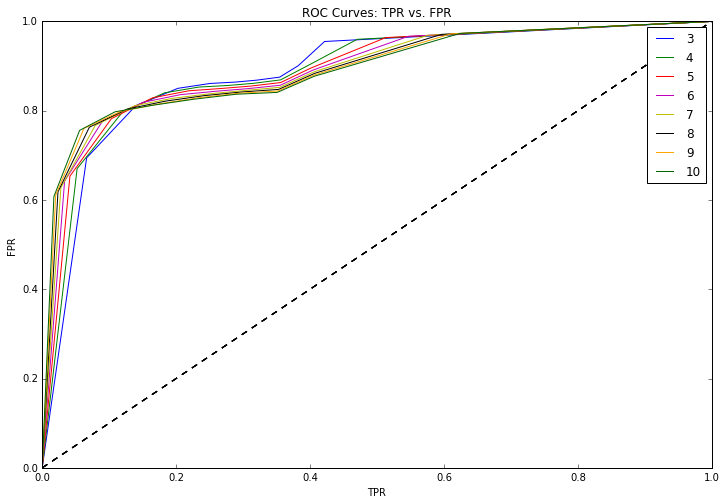

In [79]:
#  kinks represent undersampling
#  the model is undersampling points from latent features
# ideally, it would have sampled points from LF and be able to more accurately, and smoothly, 
# provide TPR and FPR, this would make the kinks a lot smaller and the curve a lot smoother 
# the solution is identify and predict on those user latent features (man, woman, black, white, rural, city,...)
# for users with 9 or more purchases, we see that the curve moves almost directly virtical because 
plot_roc_curves(metrics_dict)

In [47]:
thresholds = np.arange(2.0, 11.0, 1.0)
TPR_list, FPR_list,  pred_ratings = get_metrics(test_pred_dict, clean_test_dict, thresholds)

In [48]:
thresholds

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

A threshold value needs to be choosen in order to determine if a wine should be recommended or not. 
based on the results from the roc plot below, I recommend using either 9 which has a TPR of about 82% and a FPR of about 25%. 

Area Under the Curve 0.871


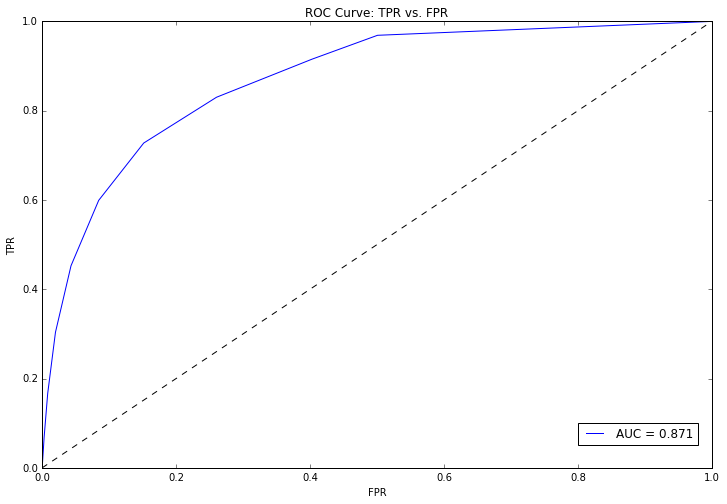

In [66]:
# this plot was created using all of the filtered ratings data (~3,000,000 ratings)
print "Area Under the Curve {:.3}".format(metrics.auc(FPR_list, TPR_list, reorder=True))
plt.figure(figsize = (12, 8));
plt.plot([0, 1], [0, 1], 'k--');
plt.title("ROC Curve: TPR vs. FPR")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.plot(FPR_list,TPR_list, 'b', label="AUC = {:.3}".format(metrics.auc(FPR_list, TPR_list, reorder=True)));
plt.legend(loc=(0.8, .05))
plt.savefig("/Users/Alexander/Wine_Recommender/Data/ROC_Curve.png");

In [97]:
# The model is outputing ratings below 1 and above 10 
Counter([ int(np.ceil(rating)) for rating in pred_ratings])

Counter({0: 285,
         1: 343695,
         2: 516900,
         3: 1216185,
         4: 1706625,
         5: 1802055,
         6: 1728630,
         7: 1500015,
         8: 1133310,
         9: 721860,
         10: 340395,
         11: 91665,
         12: 10755,
         13: 990,
         14: 105,
         15: 30})